<div class = "container" align = center>
<big><h1 align=center> Flight Ticket Price Prediction </h1></big>

</div>

#**Useful Library Import**

In [209]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

#**Import Useful Models**

In [210]:
from xgboost import XGBRegressor
import lightgbm as lgbm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error , mean_squared_error , mean_absolute_error , r2_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA

#**Reading Dataset**

In [211]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTVF_Hy83R3lxjXAOfhvAvVMf12s7SYbNIoUAmqcclSpolebRWUkjFONleBN59m8fkpLVhTZbmPkVUT/pub?output=csv')
data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,01/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,5:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,09/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,9:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,09/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,8:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


##Dataset Describition 

The given dataset has 11 columns which consists of :
1. Airline -> name of airline
2. Date of Journey -> starting date of journey
3. Source -> starting station of journey
4. Destination -> End station of journey
5. Route -> Stations which will occur between Source and destination
6. Dep_Time -> starting time of journey
7. Arrival_time -> end time of journey
8. Duration -> Time duration of the journey
9. Total_stops -> stops taken by the flight during the journey
10. Additional_info -> additional information
11. Price -> Ticket Price

#**Preprocessing of Dataset and constructing proper dataset**

Exploratory Data Analysis

checking dataset describe

In [212]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


Checking for any  null values

In [213]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Dropped null rows

In [214]:
data = data.dropna()

Checking data types of columns and looking for their correctness

In [215]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

[ ' Date of Journey' , ' Dep Time ' , ' Arrival Time ' ] are objects, so these columns needs to be converted to date and time.

In [216]:
for col in ['Date_of_Journey','Dep_Time', 'Arrival_Time']:
  data[col] = pd.to_datetime(data[col])

In [217]:
data.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

Extracting date and month from Date_of_journey, as a result there would be no use of 'Date_of_journey' column so it will be dropped.

In [218]:
data['journey_day'] = data['Date_of_Journey'].dt.day
data['journey_month'] = data['Date_of_Journey'].dt.month

In [219]:
data = data.drop(columns = ['Date_of_Journey'], axis = 1)

Similarly Extracting Hours and minutes from Departure Time and Arrival Time

In [220]:
data['Dep_Time_hour'] = data['Dep_Time'].dt.hour
data['Dep_Time_min'] = data['Dep_Time'].dt.minute

In [221]:
data['Arrival_Time_hour'] = data['Arrival_Time'].dt.hour
data['Arrival_Time_min'] = data['Arrival_Time'].dt.minute

In [222]:
data

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2022-04-25 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-04-25 05:50:00,2022-04-25 13:15:00,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2022-04-25 09:25:00,2022-06-10 04:25:00,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2022-04-25 18:05:00,2022-04-25 23:30:00,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2022-04-25 16:50:00,2022-04-25 21:35:00,4h 45m,1 stop,No info,13302,3,1,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,2022-04-25 19:55:00,2022-04-25 22:25:00,2h 30m,non-stop,No info,4107,4,9,19,55,22,25
10679,Air India,Kolkata,Banglore,CCU → BLR,2022-04-25 20:45:00,2022-04-25 23:20:00,2h 35m,non-stop,No info,4145,27,4,20,45,23,20
10680,Jet Airways,Banglore,Delhi,BLR → DEL,2022-04-25 08:20:00,2022-04-25 11:20:00,3h,non-stop,No info,7229,27,4,8,20,11,20
10681,Vistara,Banglore,New Delhi,BLR → DEL,2022-04-25 11:30:00,2022-04-25 14:10:00,2h 40m,non-stop,No info,12648,3,1,11,30,14,10


In [223]:
data = data.drop(columns = ['Dep_Time','Arrival_Time'], axis = 1)

Separate hours and minutes from duration

In [224]:
def duration_convertion(x):
    if len(x.split()) == 2:
        one = int(x.split()[0][:-1])
        two = int(x.split()[1][:-1])
        return one * 60 + two
    else:
        return int(x[:-1]) * 60

In [225]:
data["Duration"] = data["Duration"].apply(duration_convertion)

In [226]:
data

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,3,1,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,150,non-stop,No info,4107,4,9,19,55,22,25
10679,Air India,Kolkata,Banglore,CCU → BLR,155,non-stop,No info,4145,27,4,20,45,23,20
10680,Jet Airways,Banglore,Delhi,BLR → DEL,180,non-stop,No info,7229,27,4,8,20,11,20
10681,Vistara,Banglore,New Delhi,BLR → DEL,160,non-stop,No info,12648,3,1,11,30,14,10


In [227]:
data.reset_index(inplace = True)
data.drop("index",inplace = True, axis = 1)

Splitting the via column and removing all '->' from it and making each inserting each station in a separate column.

In [228]:
via = []
for i in range(len(data)):
    via.append(data["Route"][i].split("→"))   # making a list of list of routes station so that each station in route can be inserted into a different column
# via

In [229]:
lens = []
for i in via:
    lens.append((len(i) , i))  
# max(lens)[0]   

In [230]:
for i in via:
    while len(i) <= 5:
        i.append("None")

Inserting different station in separate columns

In [231]:
data['Route1'] = [row[0] for row in via]
data['Route2'] = [row[1] for row in via]
data['Route3'] = [row[2] for row in via]
data['Route4'] = [row[3] for row in via]
data['Route5'] = [row[4] for row in via]
data['Route6'] = [row[5] for row in via]

Now we don't neeed Route column

In [232]:
data = data.drop(columns = ['Route'], axis = 1)
data

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route1,Route2,Route3,Route4,Route5,Route6
0,IndiGo,Banglore,New Delhi,170,non-stop,No info,3897,24,3,22,20,1,10,BLR,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,445,2 stops,No info,7662,5,1,5,50,13,15,CCU,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,1140,2 stops,No info,13882,6,9,9,25,4,25,DEL,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,325,1 stop,No info,6218,5,12,18,5,23,30,CCU,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,285,1 stop,No info,13302,3,1,16,50,21,35,BLR,NAG,DEL,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Air Asia,Kolkata,Banglore,150,non-stop,No info,4107,4,9,19,55,22,25,CCU,BLR,None,None,None,None
10678,Air India,Kolkata,Banglore,155,non-stop,No info,4145,27,4,20,45,23,20,CCU,BLR,None,None,None,None
10679,Jet Airways,Banglore,Delhi,180,non-stop,No info,7229,27,4,8,20,11,20,BLR,DEL,None,None,None,None
10680,Vistara,Banglore,New Delhi,160,non-stop,No info,12648,3,1,11,30,14,10,BLR,DEL,None,None,None,None


In [233]:
data['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [234]:
route_columns = ['Route1','Route2','Route3','Route4','Route5','Route6']
for route in route_columns:
  data[route] = LabelEncoder().fit_transform(data[route])
data

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route1,Route2,Route3,Route4,Route5,Route6
0,IndiGo,Banglore,New Delhi,170,non-stop,No info,3897,24,3,22,20,1,10,0,13,29,13,5,1
1,Air India,Kolkata,Banglore,445,2 stops,No info,7662,5,1,5,50,13,15,2,25,1,3,5,1
2,Jet Airways,Delhi,Cochin,1140,2 stops,No info,13882,6,9,9,25,4,25,3,32,4,5,5,1
3,IndiGo,Kolkata,Banglore,325,1 stop,No info,6218,5,12,18,5,23,30,2,34,3,13,5,1
4,IndiGo,Banglore,New Delhi,285,1 stop,No info,13302,3,1,16,50,21,35,0,34,8,13,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Air Asia,Kolkata,Banglore,150,non-stop,No info,4107,4,9,19,55,22,25,2,5,29,13,5,1
10678,Air India,Kolkata,Banglore,155,non-stop,No info,4145,27,4,20,45,23,20,2,5,29,13,5,1
10679,Jet Airways,Banglore,Delhi,180,non-stop,No info,7229,27,4,8,20,11,20,0,13,29,13,5,1
10680,Vistara,Banglore,New Delhi,160,non-stop,No info,12648,3,1,11,30,14,10,0,13,29,13,5,1


In [235]:
data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

Encoding Total_stops column

In [236]:
for stop in range(len(data)):
  if(data['Total_Stops'][stop] == 'non-stop'):
    data['Total_Stops'][stop] = 0
  elif(data['Total_Stops'][stop] == '1 stop'):
    data['Total_Stops'][stop] = 1
  elif(data['Total_Stops'][stop] == '2 stops'):
    data['Total_Stops'][stop] = 2
  elif(data['Total_Stops'][stop] == '3 stops'):
    data['Total_Stops'][stop] = 3
  elif(data['Total_Stops'][stop] == '4 stops'):
    data['Total_Stops'][stop] = 4
data

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route1,Route2,Route3,Route4,Route5,Route6
0,IndiGo,Banglore,New Delhi,170,0,No info,3897,24,3,22,20,1,10,0,13,29,13,5,1
1,Air India,Kolkata,Banglore,445,2,No info,7662,5,1,5,50,13,15,2,25,1,3,5,1
2,Jet Airways,Delhi,Cochin,1140,2,No info,13882,6,9,9,25,4,25,3,32,4,5,5,1
3,IndiGo,Kolkata,Banglore,325,1,No info,6218,5,12,18,5,23,30,2,34,3,13,5,1
4,IndiGo,Banglore,New Delhi,285,1,No info,13302,3,1,16,50,21,35,0,34,8,13,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Air Asia,Kolkata,Banglore,150,0,No info,4107,4,9,19,55,22,25,2,5,29,13,5,1
10678,Air India,Kolkata,Banglore,155,0,No info,4145,27,4,20,45,23,20,2,5,29,13,5,1
10679,Jet Airways,Banglore,Delhi,180,0,No info,7229,27,4,8,20,11,20,0,13,29,13,5,1
10680,Vistara,Banglore,New Delhi,160,0,No info,12648,3,1,11,30,14,10,0,13,29,13,5,1


Since it is obvious that Source and the Route1 are to be same, so we Route1 column is dropped

In [237]:
data = data.drop(columns = ['Route1'], axis = 1)

Getting dummies for the categorical columns

In [238]:
data = pd.get_dummies(data , columns = ["Airline" , "Source" , "Destination" , "Additional_Info"] , 
                      prefix = ["Airline" , "Source" , "Destination" , "Additional_Info"] , drop_first = True)

In [239]:
data.columns

Index(['Duration', 'Total_Stops', 'Price', 'journey_day', 'journey_month',
       'Dep_Time_hour', 'Dep_Time_min', 'Arrival_Time_hour',
       'Arrival_Time_min', 'Route2', 'Route3', 'Route4', 'Route5', 'Route6',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi',
       'Additional_Info_1 Short layover', 'Additional_Info_2 Long layover',
       'Additional_Info_Business class', 'Additional_Info_Change airports',
       'Additional_Info_In-flight meal not included',
       'Additional_Info_No Info',
       'Additional_Info_No ch

In [240]:
data['Total_Stops'] = data['Total_Stops'].astype(int)

In [241]:
data.dtypes

Duration                                        int64
Total_Stops                                     int64
Price                                           int64
journey_day                                     int64
journey_month                                   int64
Dep_Time_hour                                   int64
Dep_Time_min                                    int64
Arrival_Time_hour                               int64
Arrival_Time_min                                int64
Route2                                          int64
Route3                                          int64
Route4                                          int64
Route5                                          int64
Route6                                          int64
Airline_Air India                               uint8
Airline_GoAir                                   uint8
Airline_IndiGo                                  uint8
Airline_Jet Airways                             uint8
Airline_Jet Airways Business

In [242]:
continuous_columns = ['Duration','Total_Stops','journey_day','journey_month','Dep_Time_hour','Dep_Time_min','Arrival_Time_hour','Arrival_Time_min']
data[continuous_columns] = StandardScaler().fit_transform(data[continuous_columns])

In [243]:
data

,Duration,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route2,...,Destination_New Delhi,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,-0.931601,-1.220666,3897,1.285536,-0.848450,1.654154,-0.234950,-1.800436,-0.890014,13,...,1,0,0,0,0,0,0,0,1,0
1,-0.390028,1.741432,7662,-0.872724,-1.517909,-1.303113,1.363607,-0.050909,-0.587094,25,...,0,0,0,0,0,0,0,0,1,0
2,0.978676,1.741432,13882,-0.759131,1.159928,-0.607286,0.031476,-1.363054,0.018745,32,...,0,0,0,0,0,0,0,0,1,0
3,-0.626351,0.260383,6218,-0.872724,2.164117,0.958326,-1.034229,1.407030,0.321664,34,...,0,0,0,0,0,0,0,0,1,0
4,-0.705125,0.260383,13302,-1.099909,-1.517909,0.610412,1.363607,1.115442,0.624584,34,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,-0.970988,-1.220666,4107,-0.986316,1.159928,1.132283,1.630034,1.261236,0.018745,5,...,0,0,0,0,0,0,0,0,1,0
10678,-0.961141,-1.220666,4145,1.626314,-0.513720,1.306240,1.097181,1.407030,-0.284175,5,...,0,0,0,0,0,0,0,0,1,0
10679,-0.911908,-1.220666,7229,1.626314,-0.513720,-0.781243,-0.234950,-0.342497,-0.284175,13,...,0,0,0,0,0,0,0,0,1,0
10680,-0.951295,-1.220666,12648,-1.099909,-1.517909,-0.259372,0.297903,0.094885,-0.890014,13,...,1,0,0,0,0,0,0,0,1,0


##Checking for any outliers in the dataset

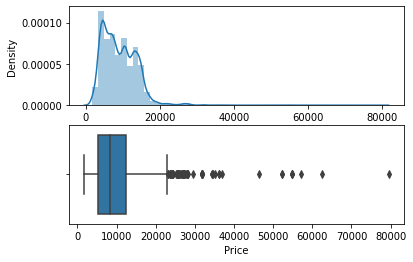

In [244]:
def plot(data,col):
    fig,(ax1,ax2)=plt.subplots(2,1)
    sns.distplot(data[col],ax=ax1)
    sns.boxplot(data[col],ax=ax2)
plot(data,'Price')

As from the above dataset we can clearly see the outliers , so I will replace all the prices > 40000 with the median value of price.

In [245]:
data['Price']=np.where(data['Price']>=40000,data['Price'].median(),data['Price'])

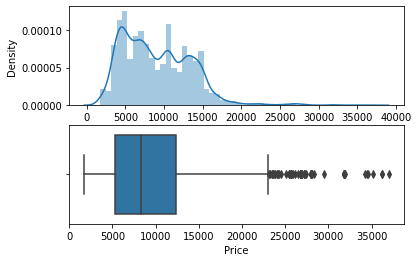

In [246]:
plot(data,'Price')

##Train test Split

In [247]:
X = data.drop(columns = ['Price'], axis = 1)
Y = data[['Price']]

In [248]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 2/3, random_state = 42)

In [249]:
x_train.reset_index(inplace = True)
x_train.drop("index",axis = 1, inplace = True)

y_train.reset_index(inplace = True)
y_train.drop("index",axis = 1, inplace = True)

x_val.reset_index(inplace = True)
x_val.drop("index",axis = 1, inplace = True)

y_val.reset_index(inplace = True)
y_val.drop("index",axis = 1, inplace = True)

x_test.reset_index(inplace = True)
x_test.drop("index",axis = 1, inplace = True)

y_test.reset_index(inplace = True)
y_test.drop("index",axis = 1, inplace = True)

#Applying Models 

In [250]:
Models = ['XGBRegressor','RandomForestRegressor','Linear Regressor','KNeighborsRegressor','AdaBoostRegressor','LGBMRegressor']
r2_scores = []
training_scores = []
testing_scores = []
cross_val_scores = []
mse_scores = []

In [251]:
training_x = pd.concat([x_train,x_val], axis = 0)
training_y = pd.concat([y_train,y_val], axis = 0)

Applying XGB Regressor

In [252]:
xgb = XGBRegressor(random_state = 42 , objective ='reg:squarederror')
xgb.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = xgb, X = training_x, y = training_y, cv = 5, scoring = "r2")
preds = xgb.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
mse_score = mean_squared_error(y_test, preds)
print(f"Training score : {xgb.score(x_train , y_train):.4f}")
print(f"Test Score : {xgb.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
print(f"MSE - Score : {mse_score:.4f}")
training_scores.append(xgb.score(x_train , y_train))
testing_scores.append(xgb.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)
mse_scores.append(mse_score)

Training score : 0.8504
Test Score : 0.8596
K-fold accuracy : 0.8337
Standard Deviation of Accuracies in k-fold : 0.0108
R2 - Score : 85.9584
MSE - Score : 2829532.0580


Applying RandomForestRegressor

In [253]:
rfc = RandomForestRegressor(random_state = 42)
rfc.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = rfc, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = rfc.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
mse_score = mean_squared_error(y_test, preds)
print(f"Training score : {rfc.score(x_train , y_train):.4f}")
print(f"Test Score : {rfc.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
print(f"MSE - Score : {mse_score:.4f}")
training_scores.append(rfc.score(x_train , y_train))
testing_scores.append(rfc.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)
mse_scores.append(mse_score)

Training score : 0.9837
Test Score : 0.9272
K-fold accuracy : 0.9007
Standard Deviation of Accuracies in k-fold : 0.0164
R2 - Score : 92.7178
MSE - Score : 1467434.1437


Applying Linear Regressor

In [254]:
lr = LinearRegression()
lr.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = lr, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = lr.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
mse_score = mean_squared_error(y_test, preds)
print(f"Training score : {lr.score(x_train , y_train):.4f}")
print(f"Test Score : {lr.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
print(f"MSE - Score : {mse_score:.4f}")
training_scores.append(lr.score(x_train , y_train))
testing_scores.append(lr.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)
mse_scores.append(mse_score)

Training score : 0.6871
Test Score : 0.6994
K-fold accuracy : 0.6804
Standard Deviation of Accuracies in k-fold : 0.0187
R2 - Score : 69.9428
MSE - Score : 6056839.3493


Applying KNeighborsRegressor




In [255]:
knr = KNeighborsRegressor()
knr.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = knr, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = knr.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
mse_score = mean_squared_error(y_test, preds)
print(f"Training score : {knr.score(x_train , y_train):.4f}")
print(f"Test Score : {knr.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
print(f"MSE - Score : {mse_score:.4f}")
training_scores.append(knr.score(x_train , y_train))
testing_scores.append(knr.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)
mse_scores.append(mse_score)

Training score : 0.8592
Test Score : 0.8075
K-fold accuracy : 0.7689
Standard Deviation of Accuracies in k-fold : 0.0169
R2 - Score : 80.7498
MSE - Score : 3879106.0029


Applying AdaBoostRegressor

In [256]:
adr = AdaBoostRegressor(random_state = 42)
adr.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = adr, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = adr.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
mse_score = mean_squared_error(y_test, preds)
print(f"Training score : {adr.score(x_train , y_train):.4f}")
print(f"Test Score : {adr.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
print(f"MSE - Score : {mse_score:.4f}")
training_scores.append(adr.score(x_train , y_train))
testing_scores.append(adr.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)
mse_scores.append(mse_score)

Training score : 0.6366
Test Score : 0.6530
K-fold accuracy : 0.5707
Standard Deviation of Accuracies in k-fold : 0.0305
R2 - Score : 65.2969
MSE - Score : 6993040.7736


Applying Lightgbm Regressor

In [257]:
lgb = lgbm.LGBMRegressor()
lgb.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = lgb, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = lgb.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
mse_score = mean_squared_error(y_test, preds)
print(f"Training score : {lgb.score(x_train , y_train):.4f}")
print(f"Test Score : {lgb.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
print(f"MSE - Score : {mse_score:.4f}")
training_scores.append(lgb.score(x_train , y_train))
testing_scores.append(lgb.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)
mse_scores.append(mse_score)

Training score : 0.9352
Test Score : 0.9228
K-fold accuracy : 0.8941
Standard Deviation of Accuracies in k-fold : 0.0128
R2 - Score : 92.2776
MSE - Score : 1556147.0455


In [258]:
score = pd.DataFrame({'Model': Models, 'Training score': training_scores, 'Testing Score': testing_scores, 'R2 - Score' : r2_scores,'Cross_val_scores' : cross_val_scores, 'MSE - Score' : mse_scores})
score.style.background_gradient(high=1,axis=0)

,Model,Training score,Testing Score,R2 - Score,Cross_val_scores,MSE - Score
0,XGBRegressor,0.850407,0.859584,85.958376,0.833664,2829532.058023
1,RandomForestRegressor,0.983705,0.927178,92.717821,0.900688,1467434.143726
2,Linear Regressor,0.687144,0.699428,69.942783,0.680370,6056839.349340
3,KNeighborsRegressor,0.859190,0.807498,80.749839,0.768938,3879106.002939
4,AdaBoostRegressor,0.636625,0.652969,65.296860,0.570653,6993040.773602
5,LGBMRegressor,0.935200,0.922776,92.277581,0.894059,1556147.045541


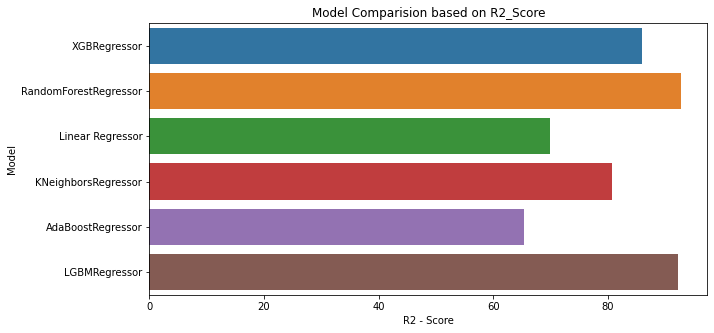

In [259]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "R2 - Score" , data = score)
plt.title("Model Comparision based on R2_Score");

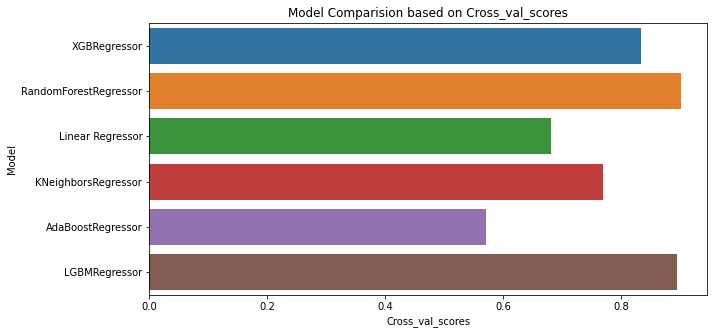

In [260]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "Cross_val_scores" , data = score)
plt.title("Model Comparision based on Cross_val_scores");

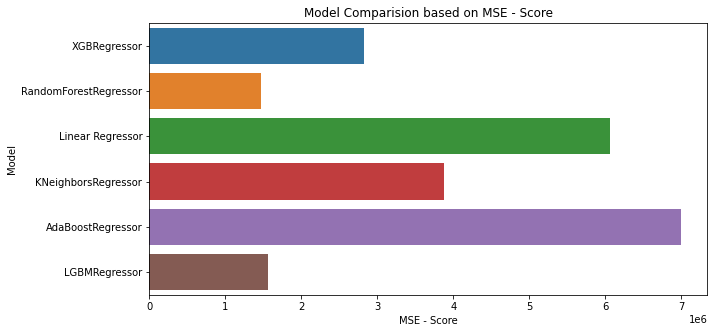

In [261]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "MSE - Score" , data = score)
plt.title("Model Comparision based on MSE - Score");

We can clearly see that Random Forest Regressor is winning

In [262]:
random_search_testing_scores = []

##Lets find the best parameter for RFC and tune it with hyperparameters using RandomSearch


In [263]:
param_dist = {
'n_estimators': list(range(10, 300, 5)),
'min_samples_leaf': list(range(1, 50)),
'max_depth': list(range(2, 30)),
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]
}

In [264]:
rfc = RandomForestRegressor()
random_search = RandomizedSearchCV(rfc, param_distributions = param_dist, n_iter = 10, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 5)

In [265]:
random_search.fit(x_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=32, n_estimators=130;, score=0.631 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=32, n_estimators=130;, score=0.630 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=32, n_estimators=130;, score=0.630 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=32, n_estimators=130;, score=0.649 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=32, n_estimators=130;, score=0.605 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=18, n_estimators=230;, score=0.861 total time=   3.4s
[CV 2/5] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=18, n_estimators=230;, score=0.835 total time=   2.9s
[CV 3/5] END 

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
             

In [266]:
random_search.best_estimator_

RandomForestRegressor(max_depth=21, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=75)

In [267]:
random_search.best_params_

{'bootstrap': True,
 'max_depth': 21,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 75}

Testing accuracy from RandomForestRegressor

In [268]:
preds = random_search.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned RandomForestRegressor is : {testing_score:.4f}")
random_search_testing_scores.append(testing_score)

The testing score by applying tuned RandomForestRegressor is : 90.5823


##Lets find the best parameter for LightGBM and tune it with hyperparameters using RandomSearch

In [269]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [270]:
lgb = lgbm.LGBMRegressor()
random_search = RandomizedSearchCV(lgb, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [271]:
random_search.fit(x_train , y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7;, score=0.868 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7;, score=0.873 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7;, score=0.865 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7;, score=0.860 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7;, score=0.851 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5;, score=0.848 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5;, score=0.850 total time=   0.1s
[CV 3/5] END colsample_by

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [272]:
random_search.best_estimator_

LGBMRegressor(colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=12,
              min_child_weight=9)

In [273]:
random_search.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 12,
 'min_child_weight': 9}

Testing accuracy from LGBMRegressor

In [274]:
preds = random_search.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned LGBMRegressor is : {testing_score:.4f}")
random_search_testing_scores.append(testing_score)

The testing score by applying tuned LGBMRegressor is : 92.7856


##Lets find the best parameter for LightGBM and tune it with hyperparameters using RandomSearch

In [275]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [276]:
xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [277]:
random_search.fit(x_train , y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[19:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.3, max_depth=12, min_child_weight=9;, score=0.916 total time=   1.0s
[19:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.3, max_depth=12, min_child_weight=9;, score=0.905 total time=   1.0s
[19:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.3, max_depth=12, min_child_weight=9;, score=0.886 total time=   1.0s
[19:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 4/5] END colsample_bytree=0.3, gamm

RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [278]:
random_search.best_estimator_

XGBRegressor(colsample_bytree=0.4, gamma=0.0, learning_rate=0.2, max_depth=8,
             min_child_weight=5)

In [279]:
random_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 5}

In [280]:
preds = random_search.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned XGBrRegressor is : {testing_score:.4f}")
random_search_testing_scores.append(testing_score)

The testing score by applying tuned XGBrRegressor is : 93.2924


In [281]:
final_testing_score = pd.DataFrame({'Model': ['RandomForestRegressor','LightGBM','XGBRegressor'], 'Testing score': random_search_testing_scores})
final_testing_score.style.background_gradient(high=1,axis=0)

,Model,Testing score
0,RandomForestRegressor,90.582327
1,LightGBM,92.785640
2,XGBRegressor,93.292400


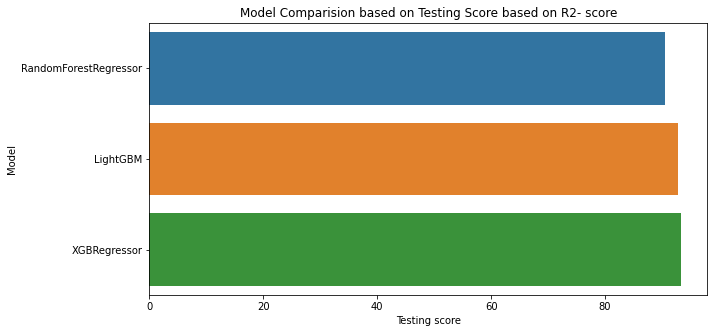

In [282]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "Testing score" , data = final_testing_score)
plt.title("Model Comparision based on Testing Score based on R2- score");

#**Applying PCA on dataset**

In [283]:
pca = PCA()
pca.fit(X)

PCA()

Text(0.5, 1.0, 'PCA visualisation')

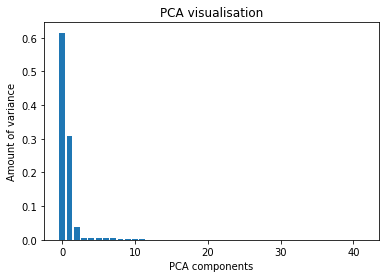

In [284]:
pca_components = list(pca.explained_variance_ratio_)
total_components = list(range(0,X.shape[1]))
plt.bar(total_components, pca_components)
plt.xlabel("PCA components")
plt.ylabel("Amount of variance")
plt.title("PCA visualisation")

From the above graph it is confirmed that first two principle components contributes to the most of variance. Hence lets see the exact value of variance which we are able to capture by taking first two PCA's.

Text(0.5, 1.0, 'PCA visualisation')

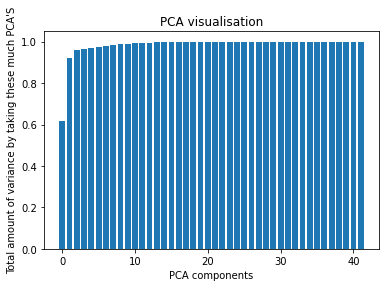

In [285]:
normalised_variance_of_pca = []
normalised_variance_of_pca.append(pca_components[0])
for i in range(1,len(pca_components)):
  normalised_variance_of_pca.append(normalised_variance_of_pca[i-1] + pca_components[i])
plt.bar(total_components, normalised_variance_of_pca)
plt.xlabel("PCA components")
plt.ylabel("Total amount of variance by taking these much PCA'S")
plt.title("PCA visualisation")

In [286]:
normalised_variance_of_pca

[0.6150931884633992,
 0.9227688920767105,
 0.9602310603666079,
 0.9663199775205772,
 0.9718328286911916,
 0.9767069146086225,
 0.9813174537856075,
 0.9853711373123951,
 0.9888217871626862,
 0.9913757581208954,
 0.9933422187477721,
 0.9950545815768501,
 0.9957948950860552,
 0.9964562357173996,
 0.9970483307270039,
 0.9975974330597096,
 0.9980586649128226,
 0.9984865292950968,
 0.998871960323814,
 0.9991757122842385,
 0.999469235721406,
 0.9996893173106719,
 0.9997920846928092,
 0.9998819541044754,
 0.9999581837461328,
 0.9999774930864805,
 0.9999838213876407,
 0.9999892320201136,
 0.9999926591950842,
 0.9999947703881308,
 0.999996084686832,
 0.999997199975419,
 0.9999979491645429,
 0.9999983931487021,
 0.9999988359567765,
 0.9999992758561559,
 0.9999996447443406,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

So from above values if we take n_components = 7 the we are able to capture about 98 % of variance.

In [287]:
values = pca.transform(X)
pca_data = pd.DataFrame(columns = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10'], data = values[:,:10])
pca_data['Price'] = Y
pca_data

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,Price
0,15.900540,1.238495,-0.272692,-1.115256,1.183977,-0.398289,-0.481939,-2.287862,0.593010,-0.087721,3897.0
1,-12.987662,13.776769,6.228482,-0.615696,-0.825967,-0.071580,1.429630,0.665934,1.616730,-0.901656,7662.0
2,-10.089364,20.561511,4.001122,1.172764,0.360514,1.125221,0.342327,-0.842224,-0.049587,-0.074901,13882.0
3,-10.324938,21.581066,-4.622670,2.188382,-0.059973,-0.618843,-1.957883,0.416767,-1.057321,-0.679356,6218.0
4,-5.313424,21.728380,-4.189789,-0.039976,-0.040512,-1.864152,0.589321,1.071679,1.417677,-1.006676,13302.0
...,...,...,...,...,...,...,...,...,...,...,...
10677,15.962536,-6.682024,0.583578,1.729765,-1.390227,-1.802866,0.293535,0.072149,-0.304018,-0.432760,4107.0
10678,15.971417,-6.692304,0.632804,-1.200362,-0.782271,-2.262804,-0.332652,-0.138695,-0.742683,-0.117706,4145.0
10679,15.883207,1.272082,-0.262852,-1.530804,-0.025908,0.538197,0.005115,-0.371797,-0.625209,0.771618,7229.0
10680,15.876020,1.273421,-0.334557,-0.380650,-0.894389,0.026344,0.147009,0.181443,1.981535,-0.003914,12648.0


In [288]:
X_pca = data.drop(columns = ['Price'], axis = 1)
Y_pca = data[['Price']]
x_train, x_test, y_train, y_test = train_test_split(X_pca,Y_pca,test_size = 0.3, random_state = 42)

In [289]:
param_dist = {
'n_estimators': list(range(10, 300, 5)),
'min_samples_leaf': list(range(1, 50)),
'max_depth': list(range(2, 30)),
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]
}

In [290]:
random_search_testing_scores_pca = []

In [291]:
rfc_pca = RandomForestRegressor()
random_search_pca_rfc = RandomizedSearchCV(rfc_pca, param_distributions = param_dist, n_iter = 10, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 5)
random_search_pca_rfc.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=43, n_estimators=265;, score=0.556 total time=   1.6s
[CV 2/5] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=43, n_estimators=265;, score=0.521 total time=   2.8s
[CV 3/5] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=43, n_estimators=265;, score=0.549 total time=   1.9s
[CV 4/5] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=43, n_estimators=265;, score=0.536 total time=   1.6s
[CV 5/5] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=43, n_estimators=265;, score=0.516 total time=   1.5s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=13, n_estimators=230;, score=0.692 total time=   0.7s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=13, n_estimators=230;, score=0.685 total time=   0.9s
[CV 3/5]

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
             

In [292]:
random_search_pca_rfc.best_estimator_

RandomForestRegressor(max_depth=18, max_features='sqrt', min_samples_leaf=8,
                      n_estimators=140)

In [293]:
random_search_pca_rfc.best_params_

{'bootstrap': True,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'n_estimators': 140}

In [294]:
preds = random_search_pca_rfc.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned RandomForestRegressor is : {testing_score:.4f}")
random_search_testing_scores_pca.append(testing_score)

The testing score by applying tuned RandomForestRegressor is : 84.0372


In [295]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [296]:
lgb_pca = lgbm.LGBMRegressor()
random_search_pca_lgb = RandomizedSearchCV(lgb_pca, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [297]:
random_search_pca_lgb.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5;, score=0.859 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5;, score=0.860 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5;, score=0.850 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5;, score=0.853 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=5;, score=0.846 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=3;, score=0.892 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=3;, score=0.882 total time=   0.1s
[CV 3/5] END colsample_by

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [298]:
random_search_pca_lgb.best_estimator_

LGBMRegressor(colsample_bytree=0.5, gamma=0.4, learning_rate=0.3, max_depth=15,
              min_child_weight=5)

In [299]:
preds_lgbm_pca = random_search_pca_lgb.predict(x_test)
testing_score_lgbm_pca = max(0 , 100 * r2_score(y_test , preds_lgbm_pca))
print(f"The testing score by applying tuned LgbmRegressor is : {testing_score_lgbm_pca:.4f}")
random_search_testing_scores_pca.append(testing_score_lgbm_pca)

The testing score by applying tuned LgbmRegressor is : 91.5142


In [300]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [301]:
xgb_pca = XGBRegressor()
random_search_pca_xgb = RandomizedSearchCV(xgb_pca, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [302]:
random_search_pca_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[19:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1;, score=0.917 total time=   0.5s
[19:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1;, score=0.900 total time=   0.5s
[19:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1;, score=0.897 total time=   0.5s
[19:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 4/5] END colsample_bytree=0.3, gamma=0

RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [303]:
preds_xgb_pca = random_search_pca_xgb.predict(x_test)
testing_score_xgb_pca = max(0 , 100 * r2_score(y_test , preds_xgb_pca))
print(f"The testing score by applying tuned XgbRegressor is : {testing_score_xgb_pca:.4f}")
random_search_testing_scores_pca.append(testing_score_xgb_pca)

The testing score by applying tuned XgbRegressor is : 92.6390


In [304]:
final_testing_score = pd.DataFrame({'Model': ['RandomForestRegressor','LightGBM','XGBRegressor'], 'Testing score': random_search_testing_scores_pca})
final_testing_score.style.background_gradient(high=1,axis=0)

,Model,Testing score
0,RandomForestRegressor,84.037245
1,LightGBM,91.514169
2,XGBRegressor,92.638982


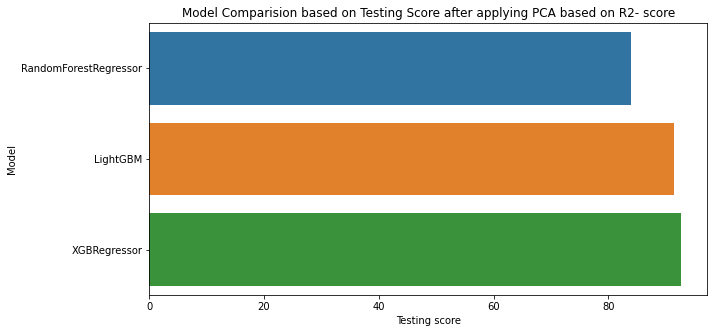

In [305]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "Testing score" , data = final_testing_score)
plt.title("Model Comparision based on Testing Score after applying PCA based on R2- score");

Since we have seen that without applying pca and after applying pca our XGBregreesor and lgbmregressor are giving us maximum r2-score so let's the final price be predicted by the average of the two price predicted by these models.

In [306]:
final_predicted_price = []
for i in range(len(preds_xgb_pca)):
  final_predicted_price.append((preds_xgb_pca[i] + preds_lgbm_pca[i]) / 2)

In [307]:
final_testing_score = max(0 , 100 * r2_score(y_test , final_predicted_price))
print(f"The testing score by applying tuned combination of XGB Regressor and LGBM Regressor is : {final_testing_score:.4f}")

The testing score by applying tuned combination of XGB Regressor and LGBM Regressor is : 92.5518


#<h2 align = center><strong> Pipeline </strong></h2>
<img src = "https://github.com/Shrut26/Flight-Ticket-Price-Prediction/blob/main/pipeline.png?raw=true" />

In [308]:
def Pipeline(X,Y):
  #data extraction and preprocessing are exactly the same done their headings
  pca = PCA()
  pca.fit(X) 
  values = pca.transform(X)
  pca_data = pd.DataFrame(columns = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10'], data = values[:,:10])
  pca_data['Price'] = Y
  final_predicted_price = []
  for i in range(len(preds_xgb_pca)):
    final_predicted_price.append((preds_xgb_pca[i] + preds_lgbm_pca[i]) / 2)
  final_testing_score = max(0 , 100 * r2_score(y_test , final_predicted_price))
  print(f"The testing score by applying tuned combination of XGB Regressor and LGBM Regressor is : {final_testing_score:.4f}")

In [309]:
Pipeline(X,Y)

The testing score by applying tuned combination of XGB Regressor and LGBM Regressor is : 92.5518
